In [2]:
%matplotlib inline

In [202]:
from boilerplate import *
import os, sys
import functional_vectorizer
from dio import dataio
from scipy import fftpack, signal, special
from imp import reload
style.use('dark_background')

In [157]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianDropout, GaussianNoise
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import regularizers
# fix random seed for reproducibility
numpy.random.seed(7)

In [161]:
# data = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_X.npy')
# data = np.load('/home/mike/ve/ml/vec_sampen_9598_376.npy')
# Y = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_Y.npy')
data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9598_376')
data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9607_384')

In [162]:
data = np.concatenate([data, data_t], axis=0)

In [163]:
print(data.shape, Y.shape, np.mean(Y, axis=0))

((7949, 16384), (6041, 1), array([ 0.07432544]))


In [167]:
data = data.reshape(data.shape[0], -1, 16)

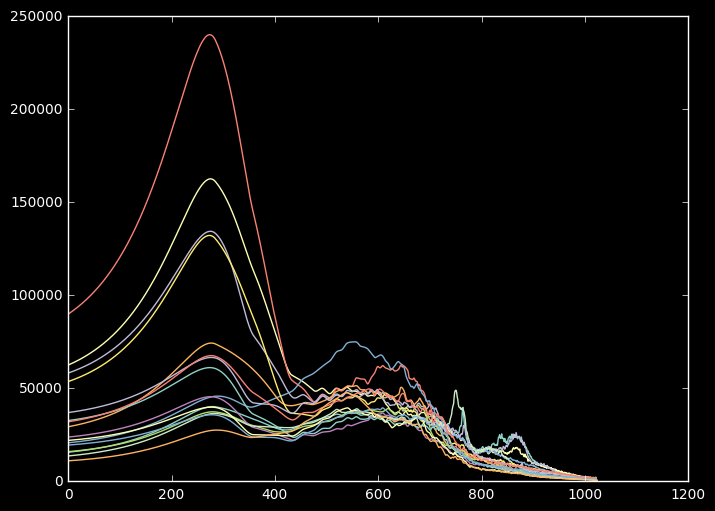

In [246]:
plot(data[0])

In [258]:
# Smooth the std?
# data_rs = signal.resample(data, 256, axis=1)
data_rs = signal.resample_poly(data, 4, 16, axis=1)

In [259]:
mean = np.mean(data_rs, axis=0)
std = np.std(data_rs, axis=0)
# gmean = np.mean(data)
# gstd = np.std(data)
mean.shape, gstd.shape

((256, 16), ())

In [260]:
# zdata = (data - mean) / (std*2)
zdata = (data_rs) / (std*2)

zdata = np.nan_to_num(zdata)
zdata.shape

(7949, 256, 16)

''

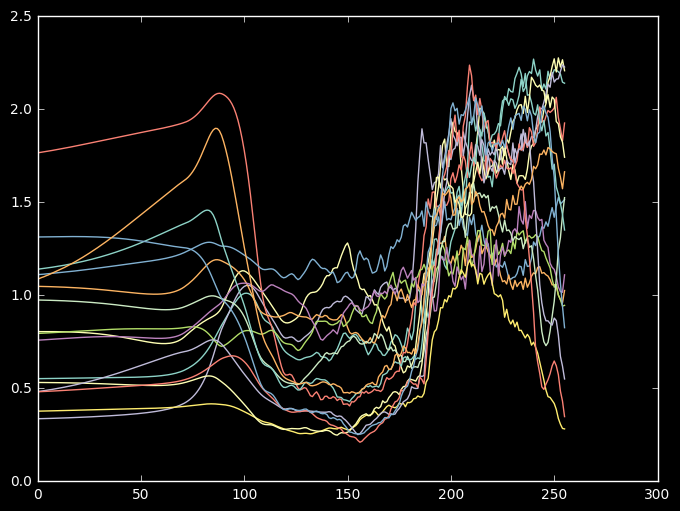

In [261]:
plt.plot(zdata[120])
''

''

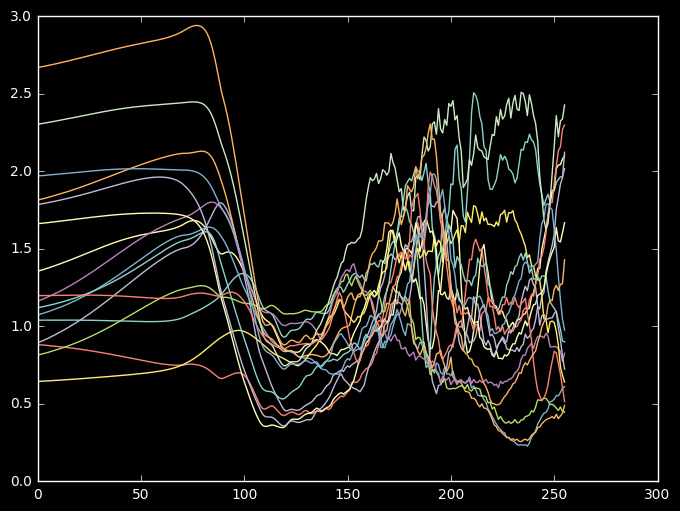

In [262]:
plt.plot(zdata[180])
''

In [172]:
# data = dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_1001_0.mat')

In [173]:
data.shape

(7949, 1024, 16)

''

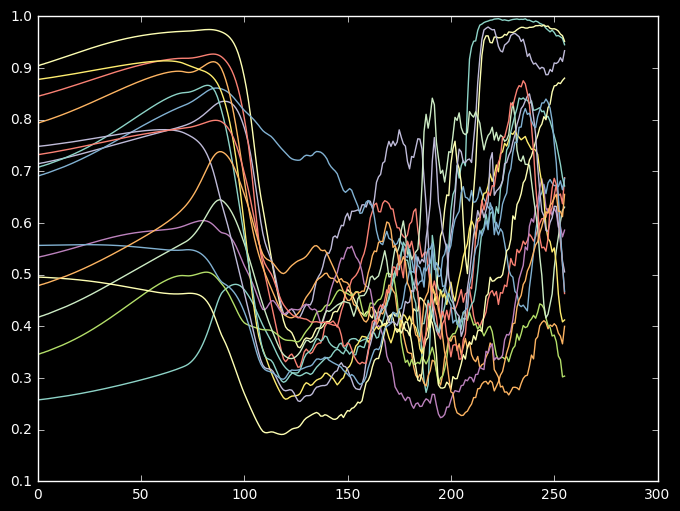

In [285]:
# ds = signal.resample(zdata[0:], 256, axis=1)
ds = zdata
ds = np.tanh(ds)

# ds = special.erf(ds)
plt.plot(ds[0])
''

In [286]:
# ds2 = ds.reshape(ds.shape[0], -1)
# ds2 = ds.reshape(ds.shape[0]*16, -1)
# Serialize the electrodes so that there is 1 electrode per sample
ds2 = []
for i in range(16):
    ds2.append( ds[:,:,i])
ds2 = np.concatenate(ds2, axis=0)
ds2.shape

(127184, 256)

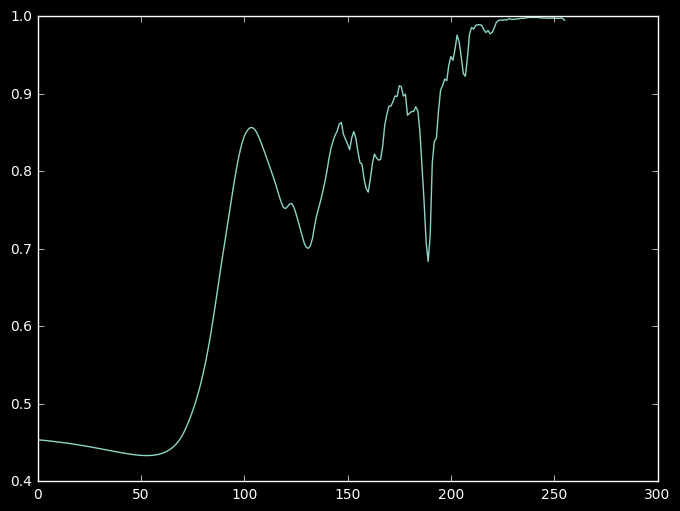

In [267]:
plt.plot(ds2[1000])

In [65]:
def convolino0():
    embedding_vecor_length = 32
    n_input_len=ds.shape[1]
    model = Sequential()
    # model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model.add(Convolution1D(nb_filter=64, filter_length=8, input_dim=1, 
                            input_length=n_input_len, border_mode='same', activation='relu'))
    model.add(MaxPooling1D(pool_length=2))
    model.add(LSTM(100))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_3 (Convolution1D)  (None, None, 64)      1088        convolution1d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling1d_3 (MaxPooling1D)    (None, None, 64)      0           convolution1d_3[0][0]            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 100)           66000       maxpooling1d_3[0][0]             
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             202         lstm_3[0][0]                     
Total params: 67290
_______________________________________________________________________

In [58]:
ds2.shape[1:]

(256,)

In [145]:
def autoencoder1(ds, compression_factor=8):
# compression_factor=20
    print('DS shape: {}'.format(ds.shape))
    in_dims = np.prod(ds.shape[1:])
    encoding_dim = int(in_dims//compression_factor)
    in_shape=ds[0].shape
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, in_shape, encoding_dim))
    
    # this is our input placeholder
    input_img = Input(shape=(in_dims,))
    # "encoded" is the encoded representation of the input
#     encoded = Dense(encoding_dim, activation='relu')(input_img)
    # Sparsity constraint
    encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.activity_l1(10e-5))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(in_dims, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)
    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.model_name = 'Autoencoder 1'
    return autoencoder, encoder, decoder
    
ae1, encoder, decoder = autoencoder1(ds2)
print(ae1.summary())

DS shape: (96656, 256)
Input Dims: 256, input shape: (256,), encoding dims: 32
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_82 (InputLayer)            (None, 256)           0                                            
____________________________________________________________________________________________________
dense_211 (Dense)                (None, 32)            8224        input_82[0][0]                   
____________________________________________________________________________________________________
dense_212 (Dense)                (None, 256)           8448        dense_211[0][0]                  
Total params: 16672
____________________________________________________________________________________________________
None


In [334]:
def autoencoder2(ds, compression_factor=16, input_noise=0.2, dropout_p=0.1, activ='tanh', final_activ='sigmoid'):
# compression_factor=20
    print('DS shape: {}'.format(ds.shape))
    in_dims = np.prod(ds.shape[1:])
    encoding_dim = int(in_dims//compression_factor)
    in_shape=ds[0].shape
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, in_shape, encoding_dim))
    
    # this is our input placeholder
    input_img = Input(shape=(in_dims,))
    encoded = GaussianNoise(input_noise)(input_img)

    encoded = Dense(encoding_dim*4, activation=activ, activity_regularizer=regularizers.activity_l1(10e-5))(encoded)
#     encoded = Dense(encoding_dim*4, activation='sigmoid')(input_img)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_p)(encoded) #batch norm before dropout
#     encoded = Dense(encoding_dim*3, activation=activ)(encoded)
#     encoded = Dropout(dropout_p)(encoded)
    encoded = Dense(encoding_dim*2, activation=activ)(encoded)
    encoded = Dropout(dropout_p)(encoded)

    encoded = Dense(encoding_dim, activation=activ)(encoded)
    # Middle Noise
    encoded = GaussianNoise(0.02)(encoded)

    #DECODED LAYER
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(encoding_dim*2, activation=activ)(encoded)
#     decoded = Dropout(dropout_p)(decoded)
    decoded = Dense(encoding_dim*4, activation=activ)(decoded)
    decoded = Dropout(dropout_p)(decoded)
    decoded = Dense(in_dims, activation=final_activ)(decoded)
    

    #MODEL
    autoencoder = Model(input=input_img, output=decoded)


    #SEPERATE ENCODER MODEL
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))

    # retrieve the last layer of the autoencoder model
    decoder_layer0 = autoencoder.layers[-4]
    decoder_layer1 = autoencoder.layers[-3]
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer3 = autoencoder.layers[-1]
    # todo: make this into a dedicated unrolling function

    # create the decoder model - unrolling the model as we go
    decoder = Model(input=encoded_input, output=decoder_layer3(decoder_layer2(
                                                decoder_layer1(decoder_layer0( encoded_input)))))

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.model_name = 'Autoencoder 1'
    return autoencoder, encoder, decoder
    
ae2, encoder2, decoder2 = autoencoder2(ds2, activ='tanh', final_activ='tanh')
print(ae2.summary())

DS shape: (127184, 256)
Input Dims: 256, input shape: (256,), encoding dims: 16
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_125 (InputLayer)           (None, 256)           0                                            
____________________________________________________________________________________________________
gaussiannoise_27 (GaussianNoise) (None, 256)           0           input_125[0][0]                  
____________________________________________________________________________________________________
dense_339 (Dense)                (None, 64)            16448       gaussiannoise_27[0][0]           
____________________________________________________________________________________________________
batchnormalization_21 (BatchNorma(None, 64)            128         dense_339[0][0]                  
___________

# Fitting the autoencoder

In [ ]:
x_train = ds2
ae2.fit(x_train, x_train, batch_size=256,shuffle=True,validation_split=.75,
                nb_epoch=50                )

In [322]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder2.predict(x_train[:1000])
decoded_imgs = decoder2.predict(encoded_imgs)

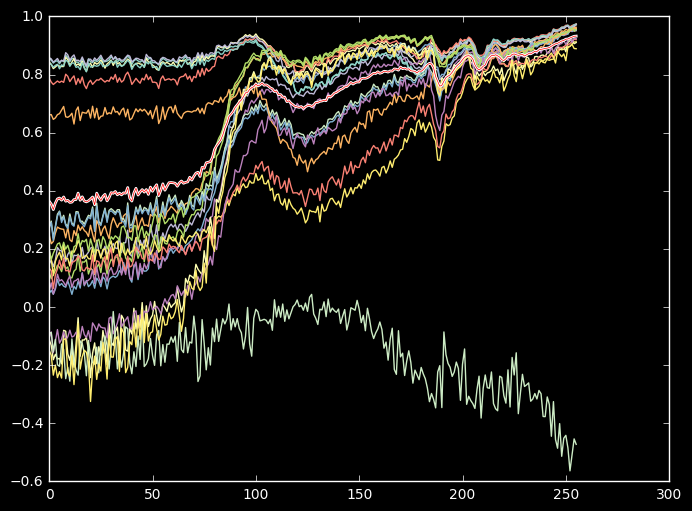

In [323]:
for i in range(20):
    plot(decoded_imgs[np.random.randint(0, decoded_imgs.shape[0])])
    
plot(np.mean(decoded_imgs, axis=0), 'w', lw=2)
plot(np.mean(decoded_imgs, axis=0), 'r', lw=.5)

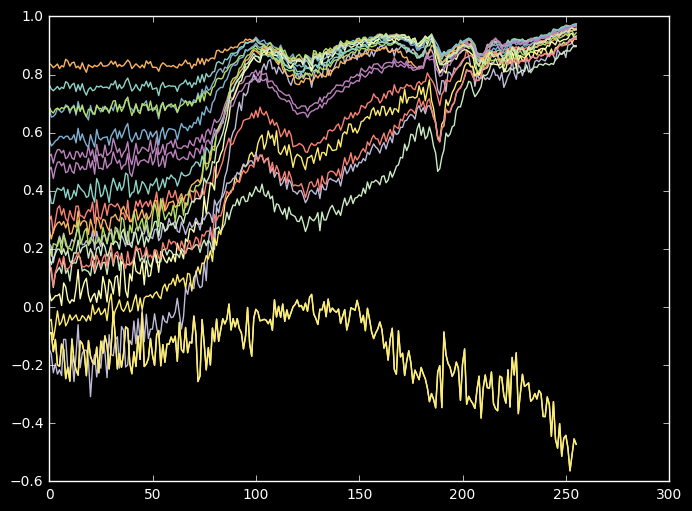

In [324]:
for i in range(1,20*17,17): 
    plt.plot(decoded_imgs[i])

[45, 62, 79, 96, 113, 130, 147, 164, 181, 198, 215, 232, 249, 266, 283, 300, 317, 334, 351, 368]


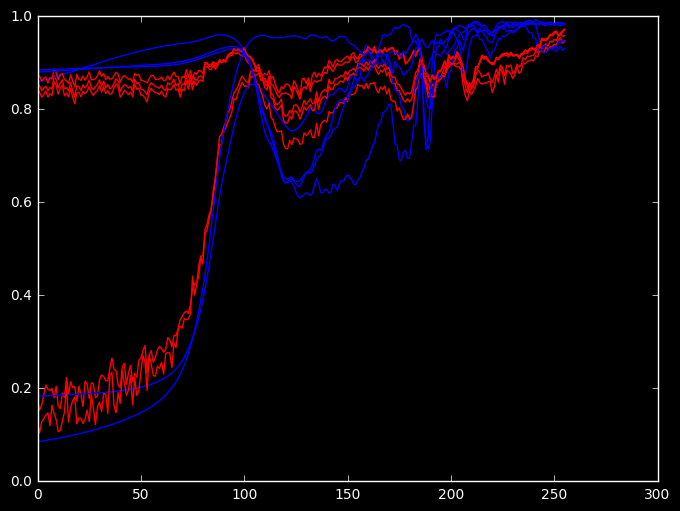

In [333]:
st = 45
nx = range(st,st+20*17,17)
print(nx)
for i in nx[:5]: 
    plt.plot(decoded_imgs[i], 'r')
    plt.plot(ds2[i], 'b')

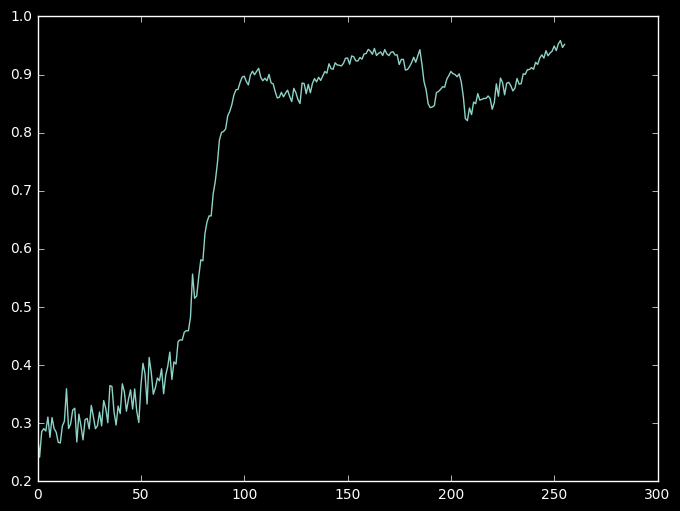

In [326]:
plot(decoded_imgs[20])

In [101]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.dio import dataio
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [36]:
reload(dataio)
print(zdata.shape, Y.shape)
d0, d1, dt = dataio.separate_sets(zdata, Y)
print(d0.shape, d1.shape)
x,y = dataio.subdiv_and_shuffle(zdata, Y, resample='up', merge=False, shuffle=False) # let keras shuffle
# x = zdata
# y = Y

((6041, 1024, 16), (6041, 1))
((5592, 1024, 16), (449, 1024, 16))
new set:  (11429, 1024, 16)
label shapes:  (5592, 1) (5837, 1) 11429


In [113]:
print(x.shape, y.shape)

((11429, 1024, 16), (11429, 1))


In [114]:
np.mean(y, axis=0)

array([ 0.51071835])

In [115]:
y

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])

In [116]:
Yv = np.asarray(y == 1).ravel()
print(Yv)
Yv = np.stack([Yv, ~Yv], axis=1)
print(Yv.shape)
Yv = np.array(Yv, dtype=int)
print(Yv.shape)
np.mean(Yv[:,0])

[False False False ...,  True  True  True]
(11429, 2)
(11429, 2)


0.51071834806194771

In [117]:
print(x.shape, Yv.shape)

((11429, 1024, 16), (11429, 2))


In [ ]:
X_train = x
# X_train = x.reshape(-1, 256,1)
# X_train /= np.amax(X_train)
y_train = Yv # .reshape(-1, 2)
print(X_train.shape, y_train.shape)
ones_rate = np.mean(Yv[:,0])
class_weight= {0:1./(1-ones_rate), 1:1./ones_rate}
print(class_weight)
model.fit(X_train, y_train, nb_epoch=3, batch_size=64, shuffle=True, class_weight=class_weight, validation_split=0.2 )

((11429, 1024, 16), (11429, 2))
{0: 2.0438125894134478, 1: 1.9580263834161382}
Train on 9143 samples, validate on 2286 samples
Epoch 1/3
5696/9143 [=================>............] - ETA: 66s - loss: 1.2607 - acc: 0.6492

In [99]:
pr = model.predict_classes(X_train)

6041/6041 [==============================] - 51s    


In [100]:
np.sum(pr)

6041

In [151]:
pr.shape

(2344,)

In [157]:
np.mean(pr == y_train[:,1]) # MOMENT OF TRUUUUUTH!!!!!!

0.67875426621160406